## Load model


In [11]:
import yaml
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from IPython.display import display, HTML
import ipywidgets as widgets
from diffusers.models import AutoencoderKL
import random

from diffusion import create_diffusion
from isolated_nwm_infer import model_forward_wrapper
from misc import transform
from models import CDiT_models
from datasets import TrainingDataset

EXP_NAME = 'nwm_cdit_xl'
MODEL_PATH = f'logs/{EXP_NAME}/checkpoints/0100000.pth.tar'

with open("config/data_config.yaml", "r") as f:
    default_config = yaml.safe_load(f)
config = default_config

with open(f'config/{EXP_NAME}.yaml', "r") as f:
    user_config = yaml.safe_load(f)
config.update(user_config)
latent_size = config['image_size'] // 8

print("loading model")
model = CDiT_models[config['model']](input_size=latent_size, context_size=config['context_size'])
ckp = torch.load(MODEL_PATH, map_location='cpu', weights_only=False)
print(model.load_state_dict(ckp["ema"], strict=True))
model.eval()
device = 'cuda:0'
model.to(device)
model = torch.compile(model)

diffusion = create_diffusion(str(250))
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-ema").to(device)
latent_size = config['image_size'] // 8



loading model
<All keys matched successfully>


## Choose starting image

In [12]:
def url_to_pil_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

def load_internet_image(url):
    from torchvision import transforms
    _transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True),
    ])
    img = url_to_pil_image(url)
    x_start = _transform(img)
    return x_start.unsqueeze(0).expand(config['context_size'], x_start.shape[0], x_start.shape[1], x_start.shape[2])

# Jupyter Notebook Cell


# List of image links
image_links = [
    #'https://raw.githubusercontent.com/amirbar/amirbar.github.io/refs/heads/master/images/recon.png',
    #'https://raw.githubusercontent.com/amirbar/amirbar.github.io/refs/heads/master/images/scand.png',
    #'https://raw.githubusercontent.com/amirbar/amirbar.github.io/refs/heads/master/images/sacson.png',
    #'https://raw.githubusercontent.com/amirbar/amirbar.github.io/refs/heads/master/images/tartan.png',
    
	#add customized images 
    #known images different from official website
    #'https://raw.githubusercontent.com/FBI-openup/nwm/main/warehouse%20Images/frame.png',
    
    # unknown warehouse (collapse)
    #'https://raw.githubusercontent.com/FBI-openup/nwm/main/warehouse%20Images/realistic-warehouse-photo1.png',
    #'https://raw.githubusercontent.com/FBI-openup/nwm/main/warehouse%20Images/warehouse2.png',
	#'https://raw.githubusercontent.com/FBI-openup/nwm/main/warehouse%20Images/obstracle+warehouse3.jpg',
    #'https://raw.githubusercontent.com/FBI-openup/nwm/main/warehouse%20Images/Resized.jpg',
    #'https://raw.githubusercontent.com/FBI-openup/nwm/main/warehouse%20Images/realwarehouse.png',
    #'https://raw.githubusercontent.com/FBI-openup/nwm/main/warehouse%20Images/Low.png',
	
	#unknown enviroment from internet
    #'https://raw.githubusercontent.com/FBI-openup/nwm/main/warehouse%20Images/livingroom.jpg',
   
	# unknown environment from offcial website
    'https://raw.githubusercontent.com/FBI-openup/nwm/main/warehouse%20Images/chateau.png',
    #unknown From roboflow
    #'https://raw.githubusercontent.com/FBI-openup/nwm/main/warehouse%20Images/cornel.png'
]

# Output widget to hold the selected link
output = widgets.Output()
x_start_link = None  # This will hold the selected link

# Function to handle image click
def on_image_click(link):
    global x_start_link
    x_start_link = link
    with output:
        output.clear_output()
        print(f"Selected image link:\n{x_start_link}")

# Create HBox of images
image_buttons = []
for link in image_links:
    img = widgets.Button(
        description='click',
        layout=widgets.Layout(width='150px', height='20px', padding='0'),
        style={'button_color': 'lightgray'}
    )

    img._dom_classes += ('image-button',)
    img_link = link  # capture current link in closure

    def on_click(b, link=img_link):
        on_image_click(link)

    img.on_click(on_click)

    # Embed image using HTML style
    img_html = f'<img src="{link}" width="150px" height="150px">'
    img_html_widget = widgets.HTML(value=img_html)
    image_buttons.append(widgets.VBox([img_html_widget, img]))

# Display the gallery
display(widgets.HBox(image_buttons))
display(output)


Output()

## Visualize navigation commands

https://raw.githubusercontent.com/FBI-openup/nwm/main/warehouse%20Images/chateau.png


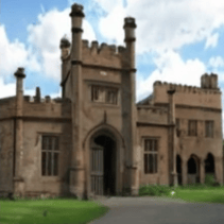

Output()

Button(description='Forward', style=ButtonStyle())

Button(description='Rotate Left', style=ButtonStyle())

Button(description='Rotate Right', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

In [3]:
x_start = load_internet_image(x_start_link)
print(x_start_link)
commands = {
    'Forward': [1,0,0],
    'Rotate Right': [0,0,-0.5],
    'Rotate Left': [0,0,0.5],
}
preds = {}

def reset():
    x_cond_pixels = x_start
    reconstructed_image=x_cond_pixels.to(device)
    preds['x_cond_pixels_display'] = (reconstructed_image[-1] * 127.5 + 127.5).clamp(0, 255).permute(1, 2, 0).to("cpu", dtype=torch.uint8).numpy()
    preds['x_cond_pixels'] = x_cond_pixels
    preds['video'] = [preds['x_cond_pixels_display']]


reset()
display(Image.fromarray(preds['x_cond_pixels_display']))
Image.fromarray(preds['x_cond_pixels_display']).save('sacson.png')

output = widgets.Output()
display(output)
rel_t = (torch.ones(1)*0.0078125).to(device)

@output.capture()
def update_image(b):

    if b.description == 'Reset':
        print("Reset clicked!")
        output.clear_output(wait=False)
        reset()
        return

    print("Button clicked!")
    y = commands[b.description]
    y = torch.tensor(y).to(device).unsqueeze(0)

    print("You entered:", b.description)
    x_cond_pixels = preds['x_cond_pixels'][-4:].unsqueeze(0).to(device)
    samples = model_forward_wrapper((model, diffusion, vae), x_cond_pixels, y, None, latent_size, device, config["context_size"], num_goals=1, rel_t=rel_t, progress=True)
    x_cond_pixels = samples # torch.clip(samples, -1., 1.)
    preds['x_cond_pixels'] = torch.cat([preds['x_cond_pixels'].to(x_cond_pixels), x_cond_pixels], dim=0)
    samples = (samples * 127.5 + 127.5).permute(0, 2, 3, 1).clamp(0,255).to("cpu", dtype=torch.uint8).numpy()
    display(Image.fromarray(samples[0]))
    preds['video'].append(samples[0])

buttons = []
for o in ["Forward", "Rotate Left", "Rotate Right", "Reset"]:
    b = widgets.Button(description=o)
    b.on_click(update_image)
    display(b)
    buttons.append(b)

https://raw.githubusercontent.com/FBI-openup/nwm/main/warehouse%20Images/chateau.png


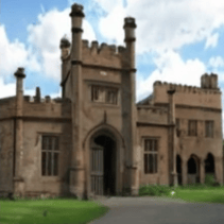

Selected tensor : torch.Size([64, 3])
Step 0 - Command : [-0.16619999706745148, -0.08649999648332596, -0.5751000046730042]


  0%|          | 0/250 [00:00<?, ?it/s]

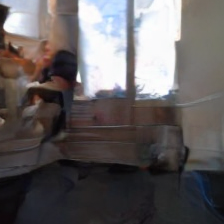

Step 1 - Command : [0.2768999934196472, -0.19480000436306, -0.10589999705553055]


  0%|          | 0/250 [00:00<?, ?it/s]

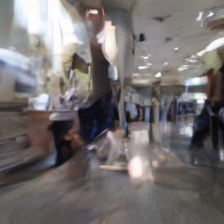

Step 2 - Command : [0.2671999931335449, -0.18639999628067017, 0.15129999816417694]


  0%|          | 0/250 [00:00<?, ?it/s]

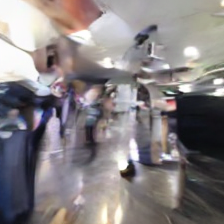

Step 3 - Command : [0.2508000135421753, -0.05779999867081642, 0.6678000092506409]


  0%|          | 0/250 [00:00<?, ?it/s]

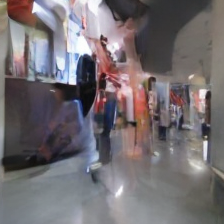

Step 4 - Command : [0.31290000677108765, 0.07400000095367432, 0.12300000339746475]


  0%|          | 0/250 [00:00<?, ?it/s]

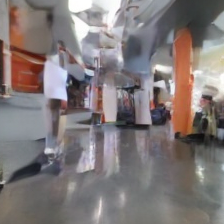

Step 5 - Command : [0.36739999055862427, 0.08320000022649765, -0.041600000113248825]


  0%|          | 0/250 [00:00<?, ?it/s]

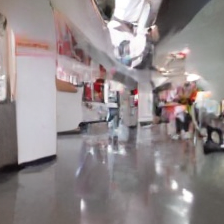

Step 6 - Command : [0.3416000008583069, 0.06889999657869339, -0.0019000000320374966]


  0%|          | 0/250 [00:00<?, ?it/s]

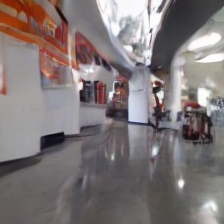

Step 7 - Command : [0.33230000734329224, 0.07349999994039536, 0.017000000923871994]


  0%|          | 0/250 [00:00<?, ?it/s]

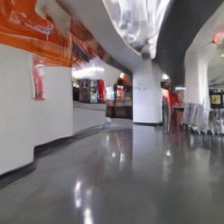

Step 8 - Command : [0.3727000057697296, 0.0771000012755394, -0.041600000113248825]


  0%|          | 0/250 [00:00<?, ?it/s]

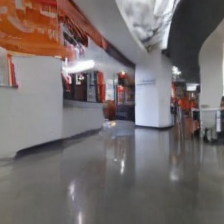

Step 9 - Command : [0.3416999876499176, 0.055799998342990875, -0.026499999687075615]


  0%|          | 0/250 [00:00<?, ?it/s]

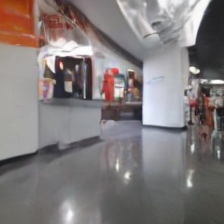

Step 10 - Command : [0.3375000059604645, 0.04529999941587448, -0.07760000228881836]


  0%|          | 0/250 [00:00<?, ?it/s]

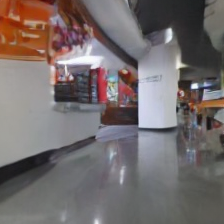

Step 11 - Command : [0.3465999960899353, -0.0010999999940395355, -0.16459999978542328]


  0%|          | 0/250 [00:00<?, ?it/s]

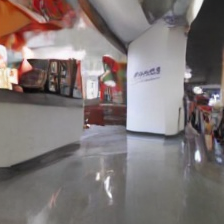

Step 12 - Command : [0.38420000672340393, -0.03310000151395798, -0.01510000042617321]


  0%|          | 0/250 [00:00<?, ?it/s]

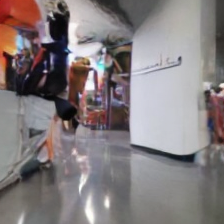

Step 13 - Command : [0.29260000586509705, -0.019300000742077827, 0.04540000110864639]


  0%|          | 0/250 [00:00<?, ?it/s]

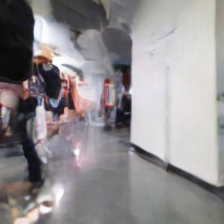

Step 14 - Command : [0.33980000019073486, -0.01209999993443489, -0.009499999694526196]


  0%|          | 0/250 [00:00<?, ?it/s]

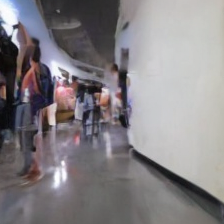

Step 15 - Command : [0.34470000863075256, -0.035599999129772186, -0.13050000369548798]


  0%|          | 0/250 [00:00<?, ?it/s]

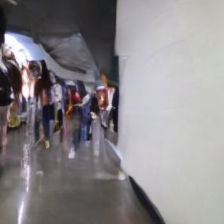

Step 16 - Command : [0.20280000567436218, -0.06499999761581421, -0.3707999885082245]


  0%|          | 0/250 [00:00<?, ?it/s]

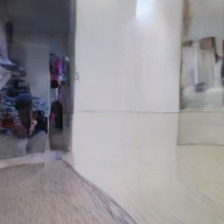

Step 17 - Command : [0.23739999532699585, -0.20329999923706055, -0.2705000042915344]


  0%|          | 0/250 [00:00<?, ?it/s]

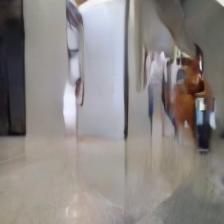

Step 18 - Command : [0.2117999941110611, -0.2547999918460846, -0.147599995136261]


  0%|          | 0/250 [00:00<?, ?it/s]

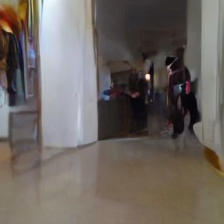

Step 19 - Command : [0.22589999437332153, -0.25839999318122864, 0.24400000274181366]


  0%|          | 0/250 [00:00<?, ?it/s]

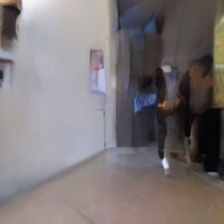

Step 20 - Command : [0.2054000049829483, -0.1023000031709671, 0.5845999717712402]


  0%|          | 0/250 [00:00<?, ?it/s]

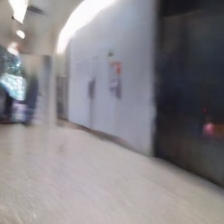

Step 21 - Command : [0.2992999851703644, 0.028200000524520874, 0.3783999979496002]


  0%|          | 0/250 [00:00<?, ?it/s]

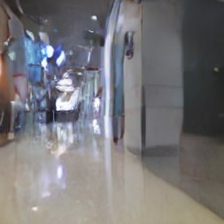

Step 22 - Command : [0.27090001106262207, 0.13699999451637268, 0.5127000212669373]


  0%|          | 0/250 [00:00<?, ?it/s]

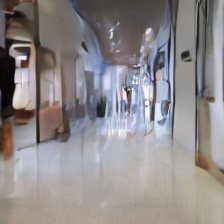

Step 23 - Command : [0.11559999734163284, 0.15889999270439148, 0.508899986743927]


  0%|          | 0/250 [00:00<?, ?it/s]

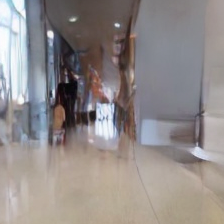

Step 24 - Command : [0.11919999867677689, 0.3398999869823456, -0.01510000042617321]


  0%|          | 0/250 [00:00<?, ?it/s]

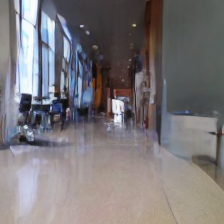

Step 25 - Command : [0.12470000237226486, 0.21549999713897705, -0.44269999861717224]


  0%|          | 0/250 [00:00<?, ?it/s]

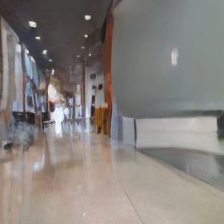

Step 26 - Command : [0.26030001044273376, 0.2087000012397766, -0.15700000524520874]


  0%|          | 0/250 [00:00<?, ?it/s]

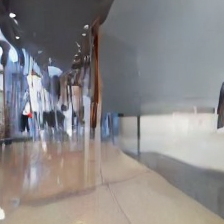

Step 27 - Command : [0.31690001487731934, 0.20559999346733093, -0.05299999937415123]


  0%|          | 0/250 [00:00<?, ?it/s]

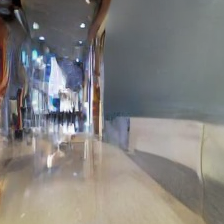

Step 28 - Command : [0.25029999017715454, 0.1543000042438507, 0.0019000000320374966]


  0%|          | 0/250 [00:00<?, ?it/s]

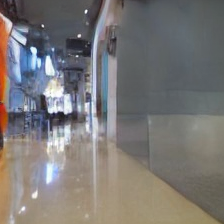

Step 29 - Command : [0.31929999589920044, 0.20270000398159027, 0.00570000009611249]


  0%|          | 0/250 [00:00<?, ?it/s]

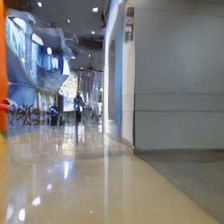

Step 30 - Command : [0.2953999936580658, 0.1673000007867813, -0.14000000059604645]


  0%|          | 0/250 [00:00<?, ?it/s]

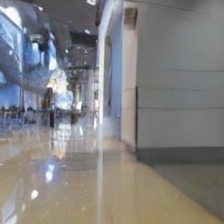

Step 31 - Command : [0.3578000068664551, 0.1266999989748001, -0.14190000295639038]


  0%|          | 0/250 [00:00<?, ?it/s]

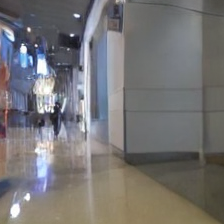

Step 32 - Command : [0.3237000107765198, 0.1006999984383583, 0.020800000056624413]


  0%|          | 0/250 [00:00<?, ?it/s]

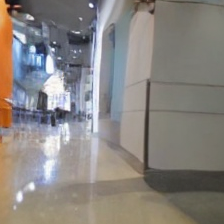

Step 33 - Command : [0.3237999975681305, 0.11079999804496765, 0.03970000147819519]


  0%|          | 0/250 [00:00<?, ?it/s]

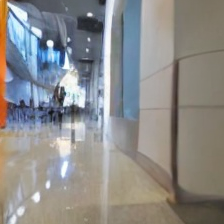

Step 34 - Command : [0.32580000162124634, 0.1387999951839447, 0.19110000133514404]


  0%|          | 0/250 [00:00<?, ?it/s]

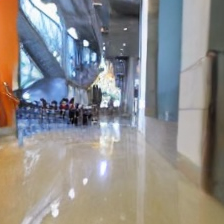

Step 35 - Command : [0.17419999837875366, 0.17599999904632568, 0.4124000072479248]


  0%|          | 0/250 [00:00<?, ?it/s]

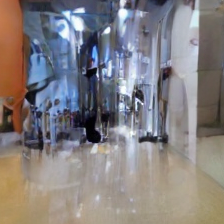

Step 36 - Command : [0.19990000128746033, 0.29840001463890076, 0.017000000923871994]


  0%|          | 0/250 [00:00<?, ?it/s]

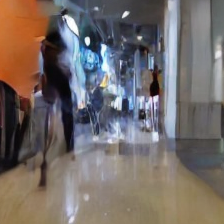

Step 37 - Command : [0.17910000681877136, 0.24050000309944153, -0.06430000066757202]


  0%|          | 0/250 [00:00<?, ?it/s]

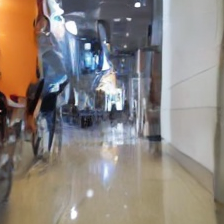

Step 38 - Command : [0.1906999945640564, 0.2281000018119812, -0.041600000113248825]


  0%|          | 0/250 [00:00<?, ?it/s]

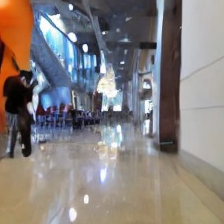

Step 39 - Command : [0.21979999542236328, 0.243599995970726, -0.022700000554323196]


  0%|          | 0/250 [00:00<?, ?it/s]

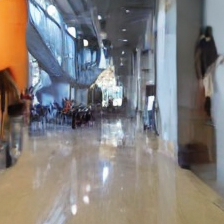

Step 40 - Command : [0.19210000336170197, 0.2176000028848648, 0.04919999837875366]


  0%|          | 0/250 [00:00<?, ?it/s]

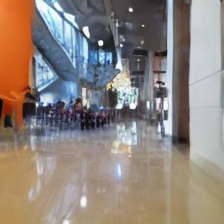

Step 41 - Command : [0.20589999854564667, 0.2847000062465668, 0.08129999786615372]


  0%|          | 0/250 [00:00<?, ?it/s]

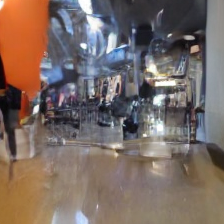

Step 42 - Command : [0.16429999470710754, 0.23549999296665192, 0.0019000000320374966]


  0%|          | 0/250 [00:00<?, ?it/s]

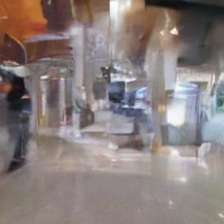

Step 43 - Command : [0.1988999992609024, 0.3084000051021576, 0.060499999672174454]


  0%|          | 0/250 [00:00<?, ?it/s]

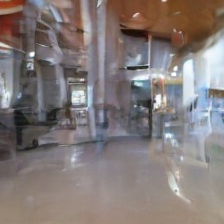

Step 44 - Command : [0.16439999639987946, 0.28029999136924744, 0.022700000554323196]


  0%|          | 0/250 [00:00<?, ?it/s]

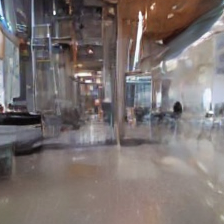

Step 45 - Command : [0.1518000066280365, 0.2655999958515167, 0.04349999874830246]


  0%|          | 0/250 [00:00<?, ?it/s]

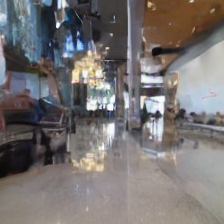

Step 46 - Command : [0.10159999877214432, 0.28290000557899475, 0.19859999418258667]


  0%|          | 0/250 [00:00<?, ?it/s]

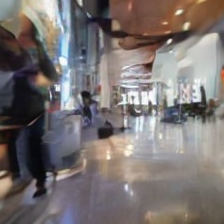

Step 47 - Command : [0.07090000063180923, 0.3084999918937683, 0.10400000214576721]


  0%|          | 0/250 [00:00<?, ?it/s]

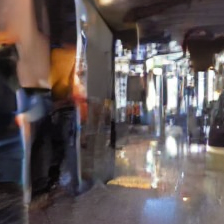

Step 48 - Command : [0.015300000086426735, 0.3490999937057495, 0.20810000598430634]


  0%|          | 0/250 [00:00<?, ?it/s]

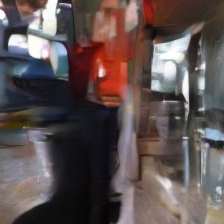

Step 49 - Command : [-0.05220000073313713, 0.30970001220703125, 0.18729999661445618]


  0%|          | 0/250 [00:00<?, ?it/s]

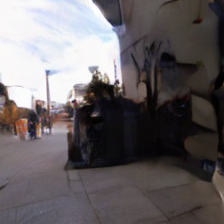

Step 50 - Command : [-0.1281999945640564, 0.33739998936653137, 0.14949999749660492]


  0%|          | 0/250 [00:00<?, ?it/s]

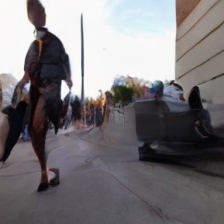

Step 51 - Command : [-0.13729999959468842, 0.29899999499320984, -0.01140000019222498]


  0%|          | 0/250 [00:00<?, ?it/s]

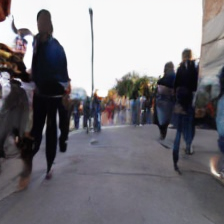

Step 52 - Command : [-0.1168999969959259, 0.3124000132083893, -0.11349999904632568]


  0%|          | 0/250 [00:00<?, ?it/s]

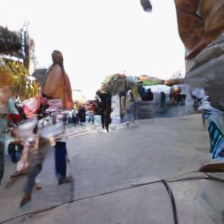

Step 53 - Command : [-0.08609999716281891, 0.3504999876022339, -0.08889999985694885]


  0%|          | 0/250 [00:00<?, ?it/s]

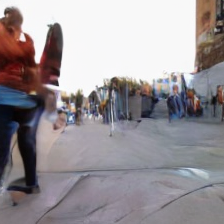

Step 54 - Command : [-0.060600001364946365, 0.31700000166893005, -0.003800000064074993]


  0%|          | 0/250 [00:00<?, ?it/s]

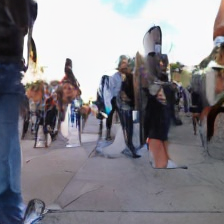

Step 55 - Command : [-0.07580000162124634, 0.35019999742507935, 0.0340999998152256]


  0%|          | 0/250 [00:00<?, ?it/s]

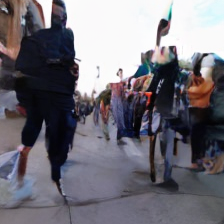

Step 56 - Command : [-0.08020000159740448, 0.31470000743865967, 0.03220000118017197]


  0%|          | 0/250 [00:00<?, ?it/s]

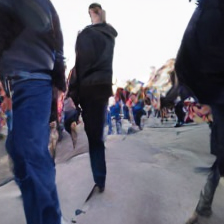

Step 57 - Command : [-0.08370000123977661, 0.31310001015663147, 0.00570000009611249]


  0%|          | 0/250 [00:00<?, ?it/s]

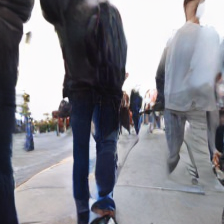

Step 58 - Command : [-0.1039000004529953, 0.34360000491142273, 0.03970000147819519]


  0%|          | 0/250 [00:00<?, ?it/s]

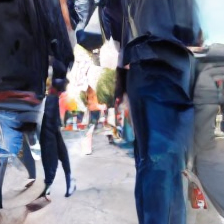

Step 59 - Command : [-0.11309999972581863, 0.2989000082015991, 0.10589999705553055]


  0%|          | 0/250 [00:00<?, ?it/s]

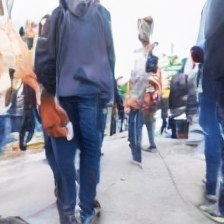

Step 60 - Command : [-0.09830000251531601, 0.19480000436306, 0.06239999830722809]


  0%|          | 0/250 [00:00<?, ?it/s]

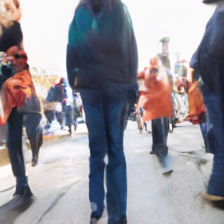

Step 61 - Command : [-0.1696999967098236, 0.27059999108314514, 0.1551000028848648]


  0%|          | 0/250 [00:00<?, ?it/s]

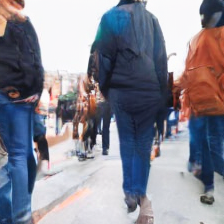

Step 62 - Command : [-0.24320000410079956, 0.2632000148296356, 0.18160000443458557]


  0%|          | 0/250 [00:00<?, ?it/s]

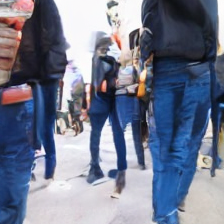

Step 63 - Command : [-0.2498999983072281, 0.21780000627040863, 0.022700000554323196]


  0%|          | 0/250 [00:00<?, ?it/s]

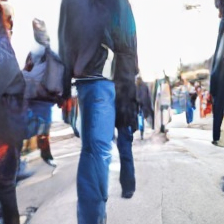

Séquence terminée. Images stockées dans preds['video'].


In [13]:
x_start = load_internet_image(x_start_link) #init image
print(x_start_link)

reset()
display(Image.fromarray(preds['x_cond_pixels_display']))
Image.fromarray(preds['x_cond_pixels_display']).save('sacson.png')

# ---- Load the tensors from the *.txt file ----
def read_tensors_from_file(filename):
    with open(filename, 'r') as f:
        content = f.read()
    
    blocs = content.split('torch.tensor')
    tensors = []

    for bloc in blocs[1:]:
        text_tensor = "torch.tensor" + bloc.strip().split(')')[0] + ')'
        try:
            tensor = eval(text_tensor, {'torch': torch})
            tensors.append(tensor)
        except Exception as e:
            print(f"Tenseur ignoré : {e}")
    
    return tensors

# ---- prediction/model config ----
preds = {}

def reset():
    x_cond_pixels = x_start
    reconstructed_image = x_cond_pixels.to(device)
    preds['x_cond_pixels_display'] = (reconstructed_image[-1] * 127.5 + 127.5).clamp(0, 255).permute(1, 2, 0).to("cpu", dtype=torch.uint8).numpy()
    preds['x_cond_pixels'] = x_cond_pixels
    preds['video'] = [preds['x_cond_pixels_display']]

# ---- Apply command ----
def apply_command(y_tensor):
    y = y_tensor.unsqueeze(0).to(device)
    x_cond_pixels = preds['x_cond_pixels'][-4:].unsqueeze(0).to(device)

    samples = model_forward_wrapper(
        (model, diffusion, vae), 
        x_cond_pixels, 
        y, 
        None, 
        latent_size, 
        device, 
        config["context_size"], 
        num_goals=1, 
        rel_t=rel_t, 
        progress=True
    )

    preds['x_cond_pixels'] = torch.cat([preds['x_cond_pixels'].to(samples.device), samples], dim=0)
    samples_disp = (samples * 127.5 + 127.5).permute(0, 2, 3, 1).clamp(0, 255).to("cpu", dtype=torch.uint8).numpy()
    preds['video'].append(samples_disp[0])
    display(Image.fromarray(samples_disp[0]))


# ---- automatic sequence from a file ----
def automatic_sequence_from_file(file):
    tensors = read_tensors_from_file(file)
    if not tensors:
        print("No tensor found")
        return

    reset()
    # random sequence select
    commands = random.choice(tensors)

    print("Selected tensor :", commands.shape)
    for i, command in enumerate(commands):
        print(f"Step {i} - Command : {command.tolist()}")
        apply_command(command)

    print("Séquence terminée. Images stockées dans preds['video'].")

# ---- use case example ----
rel_t = (torch.ones(1) * 0.0078125).to(device)

automatic_sequence_from_file("actions.txt")

# Generate a video

In [14]:

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import numpy as np
from imageio import mimsave
# np array with shape (frames, height, width, channels)
video = np.array(preds['video'])

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=500)
HTML(anim.to_html5_video())

mimsave("sequence.gif", preds["video"], fps=4)


In [ ]:
# optional: load from dataset
# dataloaders = {}

# for dataset_name in config["datasets"]:
#     data_config = config["datasets"][dataset_name]
#     for data_split_type in ["test"]: #["test"]:
#         dataset = TrainingDataset(
#             data_folder=data_config["data_folder"],
#             data_split_folder=data_config[data_split_type],
#             dataset_name=dataset_name,
#             image_size=config["image_size"],
#             min_dist_cat=config["distance"]["min_dist_cat"],
#             max_dist_cat=config["distance"]["max_dist_cat"],
#             len_traj_pred=config["len_traj_pred"],
#             context_size=config["context_size"],
#             normalize=config["normalize"],
#             goals_per_obs=1,
#             transform=transform,
#             predefined_index=None,
#             traj_stride=1,
#         )
#         dataloaders[f"{dataset_name}_{data_split_type}"] = dataset
#         print(f"Dataset: {dataset_name} ({data_split_type}), size: {len(dataset)}")

# load from dataset
# ds = dataloaders['recon_test'] # scand_test,
# x, _, _ = ds[np.random.randint(len(ds))]
# x_start = x[:config["context_size"]]
